In [1]:
!pip install --no-deps '../input/timm-package/timm-0.1.26-py3-none-any.whl' > /dev/null
!pip install --no-deps '../input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl' > /dev/null

In [2]:
import os
import gc
import sys
import math
import time
import random
from glob import glob
from ast import literal_eval
from datetime import datetime
from tqdm.notebook import tqdm
sys.path.insert(0, "../input/timm-efficientdet-pytorch")
sys.path.insert(0, "../input/omegaconf")

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

import torch
from torch import optim
from torch.optim.optimizer import Optimizer
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import wandb

In [4]:
wandb.init(project="efficientdet-training-working")

wandb: Currently logged in as: kevinmathew (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


About data splitting you can read [here](https://www.kaggle.com/shonenkov/wbf-approach-for-ensemble):

In [6]:
import numpy as np
import xml.etree.ElementTree as ET
import random

random.seed(42)


# Define the base path for the IAM Handwriting Dataset forms
INPUT_BASE_PATH = "/home/HandwrittenTextRecognition-Pytorch/src/data/OpenDataLab___IAM_Handwriting/raw/OpenDataLab___IAM_Handwriting/raw/IAM_Handwriting/forms"

def get_iam_form_path(form_id):
    """
    Given a form ID from the IAM Handwriting Dataset, returns the file path for the form image.
    
    Args:
    - form_id: A string representing the form ID (e.g., "a01-000u").
    
    Returns:
    - A string representing the path to the form image.
    """
    
    # Determine the sub-directory based on the first letter of the form ID
    first_letter = form_id[0].lower()
    if first_letter in ['a', 'b', 'c', 'd']:
        sub_dir = "A-D"
    elif first_letter in ['e', 'f', 'g', 'h']:
        sub_dir = "E-H"
    else:
        sub_dir = "I-Z"
    
    # Construct the file path
    file_path = f"{INPUT_BASE_PATH}{sub_dir}/{form_id}.png"
    
    return file_path


def extract_line_coords_from_file(file_path):
    # Parse the XML file
    tree = ET.parse(file_path)
    id = file_path.split('/')[-1].split('.')[0]
    root = tree.getroot()
    
    # List to hold coordinates of each line
    line_coords = []
    
    # Process each line in the handwritten-part
    for line in root.find('handwritten-part').findall('line'):
        # Initialize min and max values with infinity and negative infinity
        min_x, min_y = float('inf'), float('inf')
        max_x, max_y = float('-inf'), float('-inf')
        
        # Process each word in the line
        for word in line.findall('word'):
            # Process each component (cmp) in the word
            for cmp in word.findall('cmp'):
                x, y, width, height = int(cmp.attrib['x']), int(cmp.attrib['y']), int(cmp.attrib['width']), int(cmp.attrib['height'])
                
                # Update min and max values
                min_x = min(min_x, x)
                min_y = min(min_y, y)
                max_x = max(max_x, x + width)
                max_y = max(max_y, y + height)
        
        # Calculate line coordinates
        line_x = min_x
        line_y = min_y
        line_width = max_x - min_x
        line_height = max_y - min_y
        
        # Append the calculated coordinates to the list
        line_coords.append([line_x, line_y, line_width, line_height])
        final = np.concatenate([np.array([[id]] * len(line_coords)), line_coords], axis=1).tolist()

    return final


def split_list(original_list, split_ratio=0.8):

    # Shuffle the original list randomly
    shuffled_list = original_list.copy()
    random.shuffle(shuffled_list)

    # Calculate the split index based on the split ratio
    split_index = int(len(original_list) * split_ratio)

    # Split the shuffled list into two lists
    list1 = shuffled_list[:split_index]
    list2 = shuffled_list[split_index:]

    return list1, list2

  0%|          | 0/1231 [00:00<?, ?it/s]

,image_id,x,y,w,h
0,m01-115,80,0,1621,106
1,m01-115,69,162,1814,155
2,m01-115,0,314,1862,175
3,m01-115,71,500,1907,144
4,m01-115,84,671,1955,151
...,...,...,...,...,...
10678,e07-061,19,1079,1761,95
10679,e07-061,20,1249,1812,113
10680,e07-061,18,1437,1789,93
10681,e07-061,24,1613,1787,107


In [7]:
# Example usage
from glob import glob
import pandas as pd
from tqdm.notebook import tqdm

paths = glob("/home/HandwrittenTextRecognition-Pytorch/src/data/OpenDataLab___IAM_Handwriting/raw/OpenDataLab___IAM_Handwriting/raw/IAM_Handwriting/xml/*.xml")
train_paths, valid_paths = split_list(paths, split_ratio=0.8)
line_marking_train = []
line_marking_valid = []

for path in tqdm(train_paths):
    final = extract_line_coords_from_file(path)
    line_marking_train += final
    
line_marking_train = np.array(line_marking_train)
line_marking_train = pd.DataFrame(line_marking_train, columns=['image_id', 'x', 'y', 'w', 'h'])

print(f"Training Dataset:\n{line_marking_train}")

for path in tqdm(valid_paths):
    final = extract_line_coords_from_file(path)
    line_marking_valid += final
    
line_marking_valid = np.array(line_marking_valid)
line_marking_valid = pd.DataFrame(line_marking_valid, columns=['image_id', 'x', 'y', 'w', 'h'])

print(f"Validation Dataset:\n{line_marking_valid}")

  0%|          | 0/308 [00:00<?, ?it/s]

,image_id,x,y,w,h
0,e07-098,10,0,1672,76
1,e07-098,9,180,1540,72
2,e07-098,13,351,1755,97
3,e07-098,21,533,1694,87
4,e07-098,14,700,1521,96
...,...,...,...,...,...
2665,e07-000,33,375,1586,68
2666,e07-000,17,555,1793,73
2667,e07-000,1,732,1842,82
2668,e07-000,7,906,1799,88


['m01-115' '80' '0' '1621' '106']
@@@@@@@@@
  image_id    x     y     w    h
0  m01-115   80     0  1621  106
1  m01-115   69   162  1814  155
2  m01-115    0   314  1862  175
3  m01-115   71   500  1907  144
4  m01-115   84   671  1955  151
5  m01-115   92   799  1957  176
6  m01-115   73   960  2012  151
7  m01-115  113  1242  1829  117
8  m01-115  176  1461   357   73
@@@@@@@@@
[[  80    0 1621  106]
 [  69  162 1814  155]
 [   0  314 1862  175]
 [  71  500 1907  144]
 [  84  671 1955  151]
 [  92  799 1957  176]
 [  73  960 2012  151]
 [ 113 1242 1829  117]
 [ 176 1461  357   73]]
@@@@@@@@@
[[  80    0 1701  106]
 [  69  162 1883  317]
 [   0  314 1862  489]
 [  71  500 1978  644]
 [  84  671 2039  822]
 [  92  799 2049  975]
 [  73  960 2085 1111]
 [ 113 1242 1942 1359]
 [ 176 1461  533 1534]]


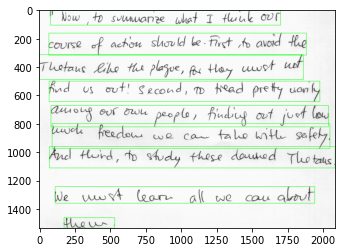

In [10]:
for row in line_marking_train.values: # [line_marking_train, marking]
    print(row)
    
    image_id = row[0]
    path = get_iam_form_path(image_id)
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    
    records = line_marking_train[line_marking_train['image_id'] == image_id]
    print("@@@@@@@@@")
    print(records)
    bbs = records[['x', 'y', 'w', 'h']].values.astype(np.int32)
    print("@@@@@@@@@")
    print(bbs)
    print("@@@@@@@@@")
    bbs[:, 2] = bbs[:, 0] + bbs[:, 2]
    bbs[:, 3] = bbs[:, 1] + bbs[:, 3]
    bbs = bbs.astype(np.int32)
    
    print(bbs)
    
    for bb in bbs:
        cv2.rectangle(image, (bb[0], bb[1]), (bb[2], bb[3]), (0, 1, 0), 2)
    
    plt.imshow(image)
    
    break

## Albumentations

In [11]:
def get_train_transforms():
    return A.Compose(
        [
#             A.RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=1, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

## Dataset

In [12]:
# TRAIN_ROOT_PATH = '../input/global-wheat-detection/train'

class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        if self.test or random.random() > 0.0:
            image, boxes = self.load_image_and_boxes(index)
        else:
            image, boxes = self.load_cutmix_image_and_boxes(index)

        # there is only one class
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target['bboxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['bboxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['bboxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['bboxes'][:,[0,1,2,3]] = target['bboxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break
        
        _, new_h, new_w = image.shape
        target["img_size"] = (new_h, new_w)
        target["img_scale"] = torch.tensor([1.0])
        
        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(get_iam_form_path(image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.marking[self.marking['image_id'] == image_id]
        boxes = records[['x', 'y', 'w', 'h']].values.astype(np.int32)
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return image, boxes

    def load_cutmix_image_and_boxes(self, index, imsize=1024):
        """ 
        This implementation of cutmix author:  https://www.kaggle.com/nvnnghia 
        Refactoring and adaptation: https://www.kaggle.com/shonenkov
        """
        w, h = imsize, imsize
        s = imsize // 2
    
        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []

        for i, index in enumerate(indexes):
            image, boxes = self.load_image_and_boxes(index)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b
            
            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
        return result_image, result_boxes

In [13]:
fold_number = 0

train_dataset = DatasetRetriever(
    image_ids=line_marking_train.image_id.values,
    marking=line_marking_train,
    transforms=get_train_transforms(),
    test=False,
)

validation_dataset = DatasetRetriever(
    image_ids=line_marking_valid.image_id.values,
    marking=line_marking_valid,
    transforms=get_valid_transforms(),
    test=True,
)

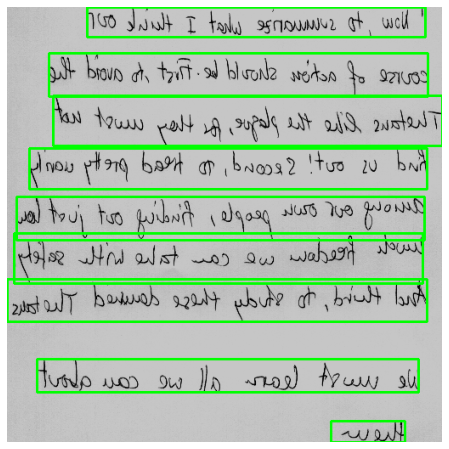

In [14]:
image, target, image_id = train_dataset[4]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);

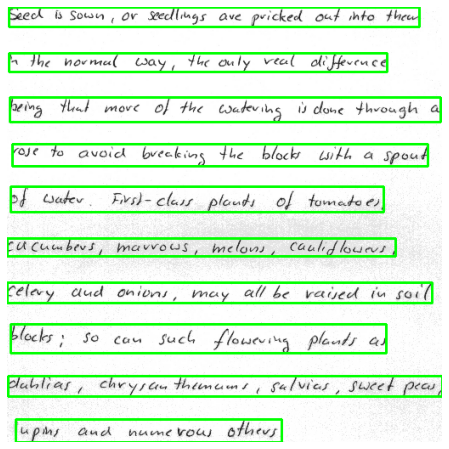

In [15]:
image, target, image_id = validation_dataset[1]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);

## Fitter

In [16]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [17]:
import warnings

warnings.filterwarnings("ignore")

class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0
        self.train_step = 0
        self.valid_step = 0
        
        self.global_train_summary_loss = AverageMeter()
        self.global_valid_summary_loss = AverageMeter()

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)
            
            wandb.log({
                'epoch': self.epoch,
                'train_epoch_avg_loss': summary_loss.avg
            })

            t = time.time()
            summary_loss = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
            
            self.model.eval()
            self.save(f'{self.base_dir}/EfficientDet-{str(self.epoch).zfill(3)}-epoch.bin')
            
            wandb.log({
                'epoch': self.epoch,
                'valid_epoch_avg_loss': summary_loss.avg
            })

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'[{step:>4d}/{len(val_loader)}] ' + \
                        f'Loss: {summary_loss.avg:>9f} | ' + \
                        f'Time: {(time.time() - t):>9f}'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                loss, _, _ = self.model(images, boxes, labels)
                summary_loss.update(loss.detach().item(), batch_size)
                self.global_valid_summary_loss.update(loss.detach().item(), batch_size)
                
                wandb.log({
                    'valid_epoch': self.epoch,
                    'valid_step': self.valid_step,
                    'valid_loss_batch': loss.detach().item(),
                    'valid_cum_avg_loss': self.global_valid_summary_loss.avg
                })
                self.valid_step += 1

        return summary_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, _, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'[{step:>4d}/{len(train_loader)}] ' + \
                        f'Loss: {summary_loss.avg:>9f} | ' + \
                        f'Time: {(time.time() - t):>9f}'
                    )
            
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]

            self.optimizer.zero_grad()
            
            loss, _, _ = self.model(images, targets)
            
            loss.backward()

            summary_loss.update(loss.detach().item(), batch_size)
            self.global_train_summary_loss.update(loss.detach().item(), batch_size)

            wandb.log({
                f'lr': self.optimizer.param_groups[0]["lr"],
                f'train_epoch': self.epoch,
                f'train_step': self.train_step,
                f'train_loss_batch': loss.detach().item(),
                f'train_loss_batch_epoch_{self.epoch}': loss.detach().item(),
                f'train_cum_avg_loss_epoch_{self.epoch}': summary_loss.avg
            })
            self.train_step += 1

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [18]:
class TrainGlobalConfig:
    num_workers = 2
    batch_size = 4 
    n_epochs = 10 # n_epochs = 40
    lr = 0.0002

    folder = 'effdet5-cutmix-augmix'

    # -------------------
    verbose = True
    verbose_step = 20
    # -------------------

    # --------------------
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss

#     SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
#     scheduler_params = dict(
#         max_lr=0.001,
#         epochs=n_epochs,
#         steps_per_epoch=int(len(train_dataset) / batch_size),
#         pct_start=0.1,
#         anneal_strategy='cos', 
#         final_div_factor=10**5
#     )
    
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=1,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )
    # --------------------

In [19]:
def collate_fn(batch):
    images, targets, image_ids = tuple(zip(*batch))
    images = torch.stack(images)
    images = images.float()

    boxes = [target["bboxes"].float() for target in targets]
    labels = [target["labels"].float() for target in targets]
    img_size = torch.tensor([target["img_size"] for target in targets]).float()
    img_scale = torch.tensor([target["img_scale"] for target in targets]).float()

    annotations = {
        "bbox": boxes,
        "cls": labels,
        "img_size": img_size,
        "img_scale": img_scale,
    }

    return images, annotations, targets, image_ids

def run_training():
    device = torch.device('cuda:0')
    net.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_loader, val_loader)

In [20]:
# del net

# gc.collect()

In [21]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet

def get_net():
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)
    checkpoint = torch.load('../input/efficientdet/efficientdet_d5-ef44aea8.pth')
    net.load_state_dict(checkpoint)
    config.num_classes = 1
    config.image_size = 512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    return DetBenchTrain(net, config)

net = get_net()

In [22]:
run_training()

Fitter prepared. Device is cuda:0

2021-06-20T05:23:14.307276
LR: 0.0002
[   0/2670] Loss:  0.000000 | Time:  0.916252
[  20/2670] Loss: 648.080711 | Time: 19.839271
[  40/2670] Loss: 593.203270 | Time: 37.953656
[  60/2670] Loss: 514.736077 | Time: 55.371020
[  80/2670] Loss: 458.655556 | Time: 73.479579
[ 100/2670] Loss: 407.563667 | Time: 91.754267
[ 120/2670] Loss: 361.337890 | Time: 109.256883
[ 140/2670] Loss: 325.185752 | Time: 127.555398
[ 160/2670] Loss: 295.446916 | Time: 145.407513
[ 180/2670] Loss: 269.065693 | Time: 163.513220
[ 200/2670] Loss: 246.484625 | Time: 180.884688
[ 220/2670] Loss: 227.445822 | Time: 198.750402
[ 240/2670] Loss: 210.789592 | Time: 216.641576
[ 260/2670] Loss: 196.357644 | Time: 234.373214
[ 280/2670] Loss: 183.788900 | Time: 252.390400
[ 300/2670] Loss: 172.590459 | Time: 269.159119
[ 320/2670] Loss: 162.587205 | Time: 286.988064
[ 340/2670] Loss: 153.745183 | Time: 303.957543
[ 360/2670] Loss: 145.762500 | Time: 321.475058
[ 380/2670] Loss: 138.